##  LANDFIRE Fire Behavior Fuel Model 40 Region Extraction

This notebook uses rasterio to read zipped tiff mosaic with surface fuel components from LANDFIRE and extract the data for a desired subregion.

Daniel Roten <d1roten@ucsd.edu>

In [3]:
import rasterio
import rasterio.mask
from shapely import geometry
import geopandas as gpd
from fiona import crs
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/dist-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [4]:
url="https://landfire.cr.usgs.gov/landfire/US_210_mosaic/LF2021_FBFM40_210_CONUS.zip"
tiffile="LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif"

Both these methods work.  Although only a fraction of the data is downloaded, the zipped tiff format is slow over cloud access.

In [5]:
#zippath=f"zip://vsicurl/{url}!{tiffile}"
zippath=f"/vsizip/vsicurl/{url}/{tiffile}"
print(zippath)

/vsizip/vsicurl/https://landfire.cr.usgs.gov/landfire/US_210_mosaic/LF2021_FBFM40_210_CONUS.zip/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif


In [6]:
src=rasterio.open(zippath)
print(type(src))
print(src.block_shapes)
display(src.files)
print(src.is_tiled)

<class 'rasterio.io.DatasetReader'>
[(128, 128)]
['/vsizip/vsicurl/https://landfire.cr.usgs.gov/landfire/US_210_mosaic/LF2021_FBFM40_210_CONUS.zip/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif', '/vsizip/vsicurl/https://landfire.cr.usgs.gov/landfire/US_210_mosaic/LF2021_FBFM40_210_CONUS.zip/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif.ovr', '/vsizip/vsicurl/https://landfire.cr.usgs.gov/landfire/US_210_mosaic/LF2021_FBFM40_210_CONUS.zip/LF2021_FBFM40_210_CONUS/Tif/LC21_F40_210.tif.aux.xml']
True


Extracting data for a rectangular area, defined in geographical coordinates.

I'm following this resource: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

First, defining a geopandas dataframe with desired corners in latitude/longitude:

In [7]:
minx, miny = -122, 39
maxx, maxy = -121, 40

bbox = geometry.box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs.from_epsg(4326))  #Word Geodetic System 1984

print(geo)

                                            geometry
0  POLYGON ((-121.00000 39.00000, -121.00000 40.0...


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The dataframe is converted to the same coordinate system as the Landfire data:

                                            geometry
0  POLYGON ((-2120391.513 2055431.155, -2091249.2...


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


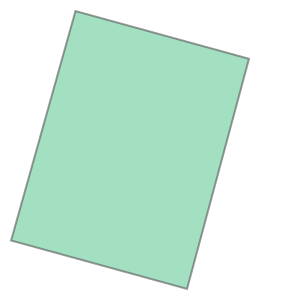

In [35]:
geo_utm=geo.to_crs(crs=src.crs.data)
print(geo_utm)
display(geo_utm.loc[0,"geometry"])

In [9]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords=getFeatures(geo_utm)
display(coords)

[{'type': 'Polygon',
  'coordinates': [[[-2120391.5132532353, 2055431.1546800162],
    [-2091249.2408845, 2163643.1761537874],
    [-2172843.3352284827, 2186078.135284207],
    [-2203122.6491676653, 2078178.7526278358],
    [-2120391.5132532353, 2055431.1546800162]]]}]

Now data outside the mask are set to the nodata value, and the region is clipped to the desired region:

In [10]:
out_img, out_transform = rasterio.mask.mask(src, shapes=coords, crop=True)

The data reflects the vegetation category described here:
https://landfire.gov/DataDictionary/f40.pdf

In [11]:
print(np.unique(out_img))

[   91    93    98    99   101   102   103   121   122   141   142   143
   144   145   147   161   162   163   165   181   182   183   184   185
   186   187   188   189 32767]


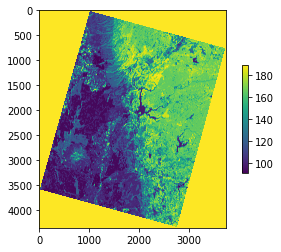

In [26]:
fig,ax=plt.subplots()

h=ax.imshow(out_img[0,:,:], origin="upper", vmin=91., vmax=189.)
fig.colorbar(h, shrink=0.5)